In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def logic_win(x,x_r):
    return (x >= x_r[0]) & (x < x_r[1])

def make_bins(xlim,dx):
    Edges_x = np.arange(xlim[0],xlim[1]+dx,dx)
    Bins_x = Edges_x[:-1]+dx/2
    return Edges_x,Bins_x

def ind_match(x,A):
    return np.argwhere(A == x)[:,0][0]

def find_key(Dict,item):
    for key in Dict.keys():
        if Dict[key] == item:
            return key
        else:
            return ''

#### Load in and do some cleaning

In [5]:
path = '../DataFrames/df_road_v3p1_zeros.csv'
df_road = pd.read_csv(path)

In [6]:
#only use road data that has availability for all accident years
Ys = 2005 #must start before or on this year
Ye = 2018 #must end this year or later

Igap = df_road.Max_year_gap == 1 #we don't want gaps
Istart = df_road.Year_start <= Ys
Iend = df_road.Year_end >= Ye
Iyears = Igap & Istart & Iend

#we also only want roads with bike lanes for shared bus lane analysis
Iselect = df_road.bikelane & Iyears

df_road_sub = df_road.loc[Iselect,:].copy()

#### Select the features to use in clustering dataframe 
- but not neccesarily use for clustering

In [7]:
f_include = ['ID', 'total', 'slight', 'serious',
       'bikelane','aadf_Road_name', 'aadf_Road_category', 'aadf_Road_type',
       'aadf_CLT_CARR', 'aadf_CLT_SEGREG', 'aadf_CLT_STEPP', 'aadf_CLT_PARSEG',
       'aadf_CLT_SHARED', 'aadf_CLT_MANDAT', 'aadf_CLT_ADVIS',
       'aadf_CLT_PRIORI', 'aadf_CLT_CONTRA', 'aadf_CLT_BIDIRE',
       'aadf_CLT_CBYPAS', 'aadf_CLT_BBYPAS', 'aadf_CLT_PARKR',
       'aadf_CLT_WATERR', 'aadf_CLT_PTIME', 'aadf_Link_length_miles',
       'aadf_Pedal_cycles', 'aadf_All_motor_vehicles',
       'aadf_All_HGVs', 'aadf_LGVs', 'aadf_Buses_and_coaches','aadf_BOROUGH',
        'aadf_Latitude','aadf_Longitude','total_dnorm',
       'total_dnorm_bvnorm', 'serious_ratio','distance_to_cp']

df_cluster = df_road_sub[f_include].copy()

#make a sample length scaled total normalized to aadf_Link_length instead
LL_med = df_cluster.aadf_Link_length_miles.median()
df_cluster['total_dnorm_LL'] = df_cluster.total.values*LL_med/df_cluster.aadf_Link_length_miles.values

#### Scale the continuous data

In [8]:
f_scale = ['aadf_Pedal_cycles', 'aadf_All_motor_vehicles',
       'aadf_All_HGVs', 'aadf_LGVs', 'aadf_Buses_and_coaches']

for f in f_scale:
    fname = f+'_s'
    mean = df_cluster[f].mean()
    std = df_cluster[f].std()
    df_cluster[fname] = (df_cluster[f].values - mean)/std

#### k-means clustering
- only use the traffic flow features to cluster road types

In [9]:
#pick which features to cluster with

#intiate list with continuous variables only 
f_cluster = ['aadf_Pedal_cycles_s', 'aadf_All_motor_vehicles_s', 'aadf_All_HGVs_s',
       'aadf_LGVs_s', 'aadf_Buses_and_coaches_s']

#add in optional classifiers
f_class = []
if len(f_class) > 1:
    for f in f_class:
        f_cluster.append(f)

##### Do a k scan and use three metrics to pick best k (we will find it is k = 3)

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

ktry = np.arange(1,10+1,1).astype(int)
Nk = len(ktry)

cluster_centers = [None]*Nk
inertias = np.zeros(Nk)
Isil = ktry != 1
ksil = ktry[Isil]
Nsil = Isil.sum()
sil_scores = np.zeros(Nsil)
sm_group = np.zeros(Nsil) #smallest group by fraction
group_sizes = [None]*Nsil

ii_sil = 0
for ii,k in enumerate(ktry):
    KM = KMeans(k)
    
    KM.fit(df_cluster[f_cluster])
    cluster_centers[ii] = KM.cluster_centers_
    
    inertias[ii] = KM.inertia_
    
    if k != 1:
        clusters = KM.predict(df_cluster[f_cluster])
        sil_scores[ii_sil] = silhouette_score(df_cluster[f_cluster],clusters)
        VCs = pd.value_counts(clusters,normalize=True)
        group_sizes[ii_sil] = VCs
        sm_group[ii_sil] = VCs.min()*k #this shows % of smallest group relative to an even split
            #among groups
        ii_sil +=1

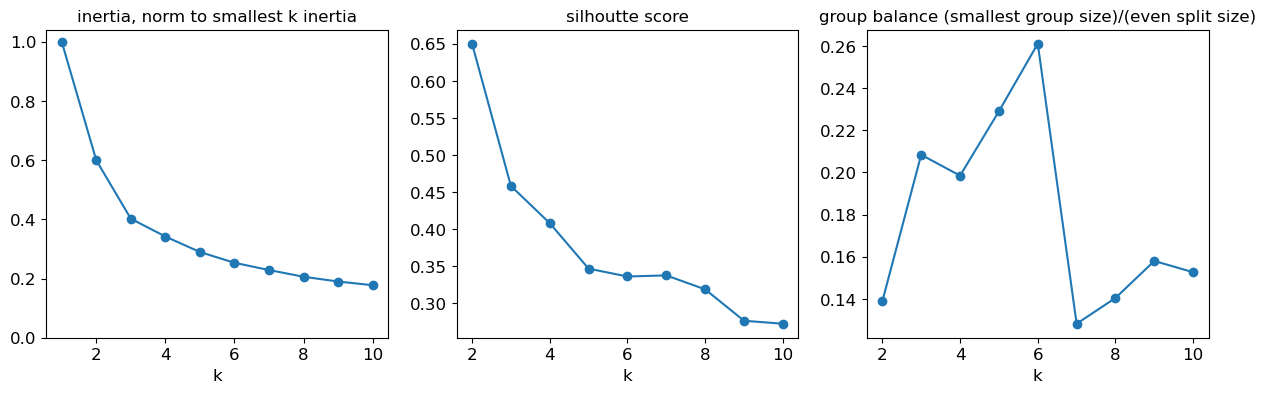

In [11]:
fig,ax = plt.subplots(1,3,figsize=(3*5,4))
labsize = 12

ii=0
ax[ii].plot(ktry,inertias/inertias[0],marker='o')
ax[ii].set_xlabel('k',fontsize=labsize)
ax[ii].set_title('inertia, norm to smallest k inertia',fontsize=labsize)
ax[ii].tick_params(labelsize=labsize)
ax[ii].set_ylim(0)

ii=1
ax[ii].plot(ksil,sil_scores,marker='o')
ax[ii].set_xlabel('k',fontsize=labsize)
ax[ii].set_title('silhoutte score',fontsize=labsize)
ax[ii].tick_params(labelsize=labsize)

ii=2
ax[ii].plot(ksil,sm_group,marker='o')
ax[ii].set_xlabel('k',fontsize=labsize)
ax[ii].set_title('group balance (smallest group size)/(even split size)',fontsize=labsize)
ax[ii].tick_params(labelsize=labsize)

plt.show()

#### Make vector component plots for k=3 clusters and define groups

In [12]:
#get cluster centers for k = 3
k = 3
ind = ind_match(k,ktry)
Nfeat_c = len(f_cluster)
Nroads = df_cluster.shape[0]

KM = KMeans(k)
KM.fit(df_cluster[f_cluster])
cluster_centers = KM.cluster_centers_
cluster_IDs = KM.predict(df_cluster[f_cluster])

#order groups based on bike traffic volume
group_names = np.array(['Urban-Bikeways','Suburban Roads','Expressways'])
groupind_bvsort = np.flip(np.argsort(cluster_centers[:,0])) #roads with most bike traffic are group 0 now
Igroup = np.zeros((k,Nroads)).astype(bool)
for ii in range(k):
    Igroup[ii] = cluster_IDs == groupind_bvsort[ii]

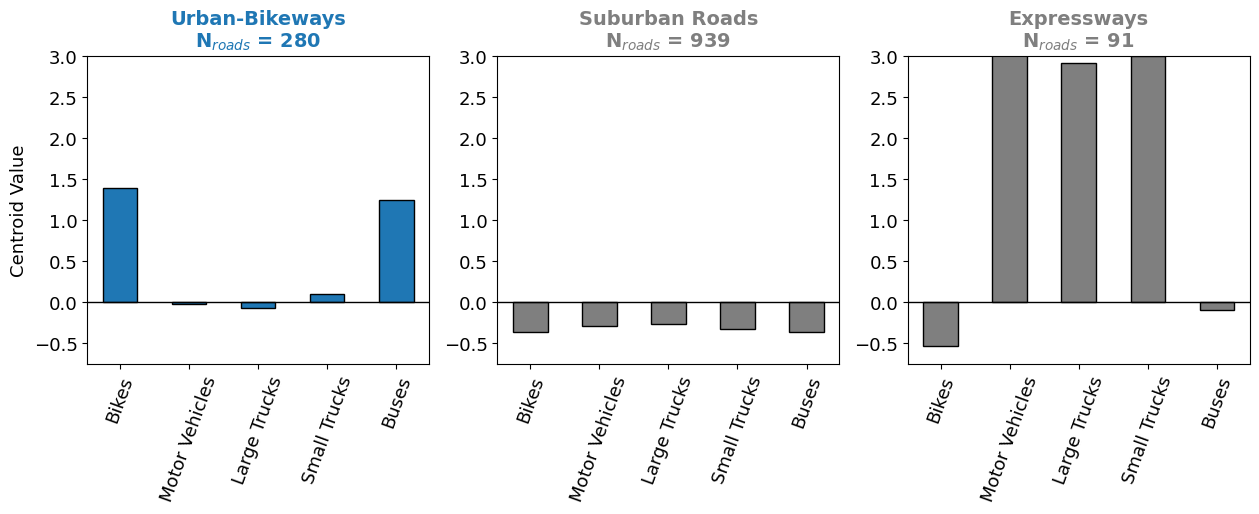

In [17]:
ticklabs_present = ['Bikes','Motor Vehicles','Large Trucks','Small Trucks','Buses']

from matplotlib.cm import get_cmap
CMAP = get_cmap('tab10')
CLR_title = {'Urban-Bikeways':CMAP(0),'Suburban Roads':CMAP(7),'Expressways':CMAP(7)}
CLR_face = {'Urban-Bikeways':CMAP(0),'Suburban Roads':CMAP(7),'Expressways':CMAP(7)}

fig,ax = plt.subplots(1,k,figsize=(k*5,4))
labsize=13
ticksize=13
titlesize=14

for ii in range(k):
    
    gname = group_names[ii]
    
    I = Igroup[ii]
    n_roads_group = I.sum()
    frac_group = n_roads_group/Nroads
    ind_g = groupind_bvsort[ii]
    
    ax[ii].bar(np.arange(Nfeat_c),cluster_centers[ind_g],width=0.5,edgecolor='black',facecolor=CLR_face[gname])
    ax[ii].set_ylim(-0.75,3)
    ax[ii].set_xticks(np.arange(Nfeat_c))
    ax[ii].set_xticklabels(ticklabs_present,rotation=70,fontsize=12)
    ax[ii].tick_params(labelsize=labsize)
    ax[ii].set_title('%s\nN$_{roads}$ = %i'%(group_names[ii],n_roads_group),color=CLR_title[gname],weight='bold',
                    fontsize=titlesize)
    
    ax[ii].axhline(0,0,1,linewidth=1,color='black')
    if ii == 0:
        ax[ii].set_ylabel('Centroid Value',fontsize=labsize)
    
import os
path = os.getcwd()
fname = os.path.join(path,'ClusterCenters.png')
plt.savefig(fname,dpi=500, format=None, metadata=None,
        bbox_inches='tight',
        facecolor='none', edgecolor=None)
plt.show()

In [18]:
#calculate % of urban-bikeways that are shared bike-bus lanes
ig = 0
Ishared = Igroup[ig] & (df_cluster.aadf_CLT_SHARED == True) & (df_cluster.aadf_CLT_CARR == True)
shared_frac = Ishared.sum()/Igroup[ig].sum()
print(shared_frac)

0.8321428571428572


#### Get accident statistics for k=3 clusters

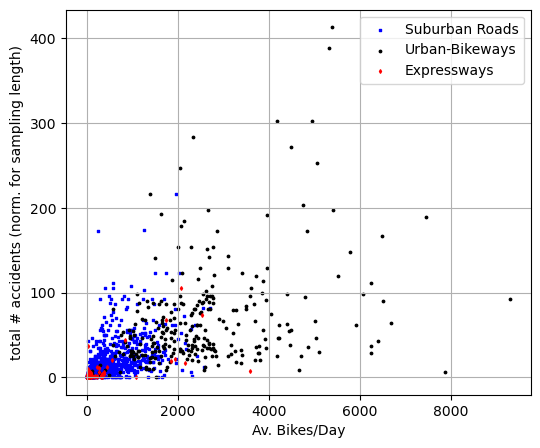

In [19]:
#make scatter plot of total vs. aadf_Bike_volume, hue based on group

group_c = {'Urban-Bikeways':'black','Suburban Roads':'blue','Expressways':'red'}
group_m = {'Urban-Bikeways':'o','Suburban Roads':'s','Expressways':'d'}
msize=3
group_size = {'Urban-Bikeways':msize,'Suburban Roads':msize,'Expressways':msize}
group_order = ['Suburban Roads','Urban-Bikeways','Expressways'] #order to plot in 

fy = 'total_dnorm_LL' #you can use total_dnorm alternatively, this is normalized to av. "distance_to_cp". Problem is, that feature is undefined when there is 0 accidents

fig,ax = plt.subplots(figsize=(6,5))
labsize=10
ticksize=10
legsize=10

for g in group_order:
    ig = ind_match(group_names,g)
    ax.scatter(df_cluster.loc[Igroup[ig],'aadf_Pedal_cycles'],df_cluster.loc[Igroup[ig],fy],marker=group_m[g],color=group_c[g],
              label='%s'%(g),s=group_size[g])
    
ax.set_xlabel('Av. Bikes/Day',fontsize=labsize)
ax.set_ylabel('total # accidents (norm. for sampling length)',fontsize=labsize)
ax.tick_params(labelsize=ticksize)
ax.legend(fontsize=legsize)
ax.grid('on')
plt.show()

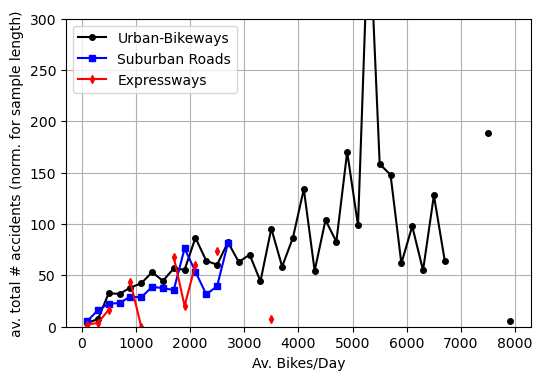

In [20]:
#Make av. total_dnorm vs. bike volume histograms for groups and plot

dbv = 200
bv_r = (0,8000)
e_bv,b_bv = make_bins(bv_r,dbv)
Nbv = len(b_bv)

fy = 'total_dnorm_LL'

H_tot_dnorm_bv = np.zeros((k,Nbv))
for ii in range(k):
    I = Igroup[ii]
    H,_ = np.histogram(df_cluster.loc[I,'aadf_Pedal_cycles'],bins=e_bv)
    H_tot,_ = np.histogram(df_cluster.loc[I,'aadf_Pedal_cycles'],bins=e_bv,weights=df_cluster.loc[I,fy])
    H_tot_dnorm_bv[ii] = H_tot/H
    
gname_plt = ['Urban-Bikeways','Suburban Roads','Expressways']

fig,ax = plt.subplots(figsize=(6,4))
labsize=10
ticksize=10
legsize=10
                      
for g in gname_plt:
    ig = ind_match(group_names,g)
    ax.plot(b_bv,H_tot_dnorm_bv[ig],marker=group_m[g],color=group_c[g],
              label='%s'%g,markersize=4)
    
ax.set_xlabel('Av. Bikes/Day',fontsize=labsize)
ax.set_ylabel('av. total # accidents (norm. for sample length)',fontsize=labsize)
ax.tick_params(labelsize=ticksize)
ax.legend(fontsize=legsize)
ax.set_ylim(0,300)
ax.grid('on')
plt.show()                      

#### Estimate error in link-length for urban-bikeways cluster
- need to account for scaling error to sample length
- estimate by comparing averaged "distance_to_cp" to link_length
- We've seen using av. distance_to_cp for scaling is more reliable for roads with many accidents, but we need to use link length since some roads have few or zero
- if we take averaged "distance_to_cp" as close to true value of sampling length, then we can calculate standard deviation
- $\sigma^{2}$ = $\frac{1}{N}{\Sigma}(0.5 LL - d2cp_{av})^{2}$

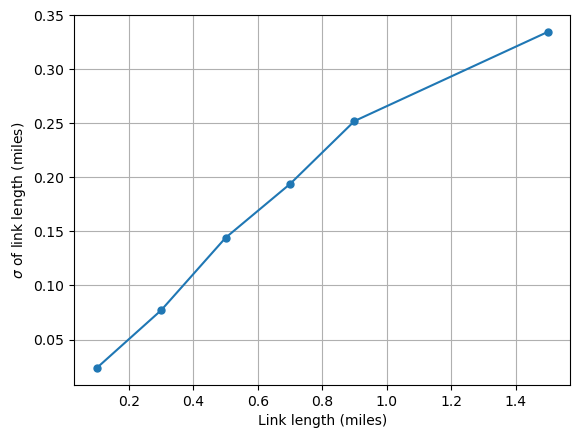

LL-total corr = 0.62


In [21]:
#calculate sigma^2 for urban cluster across whole set

gk = ind_match(group_names,'Urban-Bikeways')
Iacc = df_cluster.total >= 20
I = Iacc & Igroup[gk]

sigma_LL_urb_all = np.sqrt(1/I.sum()*np.sum(np.power(df_cluster.loc[I,'aadf_Link_length_miles'].values-df_cluster.loc[I,'distance_to_cp'].values,2)))

#calculate sigma vs. LL

LL_r = (0,1)
dLL = 0.2
e_LL,b_LL = make_bins(LL_r,dLL)
e_LL = np.concatenate([e_LL,[2]]) #make large bin for 1-2 miles data
b_LL = np.concatenate([b_LL,[1.5]])
Nb_LL = len(b_LL)

b = 0.375
xplt = np.linspace(0,1.5,10)
yplt = b*xplt

fx = 'aadf_Link_length_miles'
sigma_LL_urb = np.zeros(Nb_LL)
for ii in range(Nb_LL):
    Ibin = logic_win(df_cluster[fx].values,(e_LL[ii],e_LL[ii+1]))
    I = Ibin & Igroup[gk] & Iacc
    sigma_LL_urb[ii] = np.sqrt(1/I.sum()*np.sum(np.power(0.5*df_cluster.loc[I,'aadf_Link_length_miles'].values-df_cluster.loc[I,'distance_to_cp'].values,2)))
    
plt.plot(b_LL,sigma_LL_urb,marker='.',markersize=10)
plt.xlabel('Link length (miles)')
plt.ylabel('$\sigma$ of link length (miles)')
plt.grid('on')
#plt.plot(xplt,yplt)
plt.show()

#finally, calculate pearson corr. for LL and total
    #this is needed to calculate error in scaled quantites later
f1 = 'aadf_Link_length_miles'
f2 = 'total'
p_LL_tot_urb = df_cluster.loc[Iacc&Igroup[gk],[f1,f2]].corr()[f1][f2]
print('LL-total corr = %.2f'%p_LL_tot_urb)

#### Look at normalized total accidents vs. av. bus traffic for shared and unshared lanes

IndexError: list index out of range

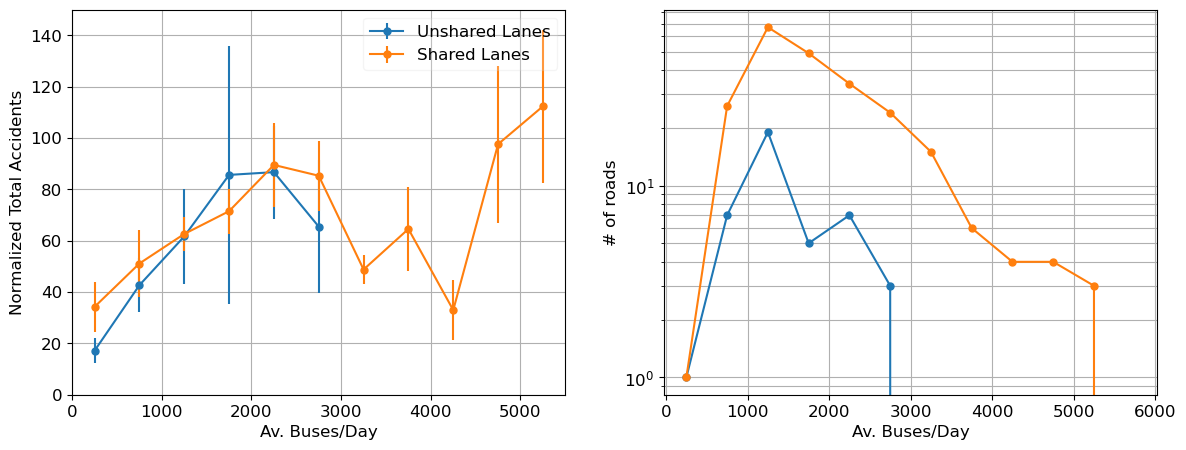

In [22]:
group = 'Urban-Bikeways'
gk = ind_match(group_names,group)

f_class = 'aadf_CLT_SHARED'
f_class_2 = 'aadf_CLT_CARR' #this must be true for Shared = True to be a shared bus lane 
f_bin = 'aadf_Buses_and_coaches'
fy = 'total_dnorm_LL'

dbus = 500
bus_r = (0,6000)
e_bus,b_bus = make_bins(bus_r,dbus)
Nbus = len(b_bus)

BVmed = df_cluster.loc[Igroup[gk],'aadf_Pedal_cycles'].median()
minBV = 100

H_tot_bus = np.zeros((2,Nbus))
BoolVal = [False,True]
for ii in range(2):
    I = Igroup[gk] & (df_cluster[f_class] == BoolVal[ii]) & (df_cluster[f_class_2] == True) & (df_cluster['aadf_Pedal_cycles'] > minBV)
    H,_ = np.histogram(df_cluster.loc[I,f_bin],bins=e_bus)
    H_tot,_ = np.histogram(df_cluster.loc[I,f_bin],bins=e_bus,weights=df_cluster.loc[I,fy]*BVmed/df_cluster.loc[I,'aadf_Pedal_cycles'].values)
    H_tot_bus[ii] = H_tot/H
    
#get errorbars for averages
    #we assume the uncertainty in annually averaged bike volume in urban core is small compared to accident totals
fquant = 'total'
fnorm = 'aadf_Link_length_miles'
Lmed = df_cluster.aadf_Link_length_miles.median()
H_err = np.zeros((2,Nbus))
N_err = np.zeros((2,Nbus))
for ii in range(2):
    Iselect = Igroup[gk] & (df_cluster[f_class] == BoolVal[ii]) & (df_cluster[f_class_2] == True) & (df_cluster['aadf_Pedal_cycles'] > minBV)
    for jj in range(Nbus):
        Ibin = logic_win(df_cluster[f_bin].values,(e_bus[jj],e_bus[jj+1]))
        I = Ibin & Iselect
        N = I.sum()
        if N > 0: 
            N_err[ii,jj] = N
            quants = df_cluster.loc[I,fquant].values
            Izero = quants == 0
            quants[Izero] = 1
            norms = df_cluster.loc[I,fnorm].values
            bv_norms = df_cluster.loc[I,'aadf_Pedal_cycles'].values
            sig_norms = np.zeros(N)
            for kk in range(N):
                Iedge = e_LL >= norms[kk] #using e_LL from above in sigma calc
                if Iedge.sum() <= 1:
                    sig_norms[kk] = sigma_LL_urb[-1]
                else:
                    sig_norms[kk] = sigma_LL_urb[Iedge[:-1]][0]
            sig_quants = np.sqrt(quants)
            H_err[ii,jj] = BVmed*Lmed/N*np.sqrt(np.sum( ((quants/(norms*bv_norms))**2)*((sig_quants/quants)**2 +\
                                                                       (sig_norms/norms)**2 -\
                                                                       2*p_LL_tot_urb*sig_quants*sig_norms/(quants*norms)) ))

            
fig,ax = plt.subplots(1,2,figsize=(2*7,5))
labsize=12
ticksize=12
legsize=12
msize = 10
                      
nn = 0
for ii in range(2):
    if BoolVal[ii]:
        lab_str = 'Shared Lanes'
    else:
        lab_str = 'Unshared Lanes'
    ax[nn].errorbar(b_bus,H_tot_bus[ii],H_err[ii],marker='.',
              label='%s'%(lab_str),markersize=msize)
    
ax[nn].set_xlabel('Av. Buses/Day',fontsize=labsize)
ax[nn].set_ylabel('Normalized Total Accidents',fontsize=labsize)
ax[nn].tick_params(labelsize=ticksize)
ax[nn].legend(fontsize=legsize,fancybox=True,framealpha=0.2)
ax[nn].set_ylim(0,150)
ax[nn].grid('on')

nn = 1
for ii in range(2):
    if BoolVal[ii]:
        lab_str = 'Shared Lane'
    else:
        lab_str = 'Unshared Lane'
    ax[nn].plot(b_bus,N_err[ii],marker='.',
              label='%s\n%s'%(group,lab_str),markersize=msize)
    
ax[nn].set_xlabel('Av. Buses/Day',fontsize=labsize)
ax[nn].set_ylabel('# of roads',fontsize=labsize)
ax[nn].tick_params(labelsize=ticksize)
#ax[nn].legend(fontsize=legsize)
#ax[nn].set_ylim(0,175)
ax[nn].set_yscale('log')
ax[nn].grid('on',which='both')
#ax[nn].set_yticklabels([1,10])

newtext = ax[nn].get_yticklabels()

for ii,txt in enumerate(newtext):
    A = txt.get_text()
    exp = A.split('^{')[1].split('}')[0]
    if int(exp) < 0:
        newstr = '%.1f'%(10**int(exp))
    else:
        newstr = '%i'%(10**int(exp))
    txt.set_text(newstr)
    newtext[ii] = txt
ax[nn].set_yticklabels(newtext)

path = os.getcwd()
fname = os.path.join(path,'SharedLaneResults.png')
plt.savefig(fname,dpi=500, format=None, metadata=None,
        bbox_inches='tight',
        facecolor='white', edgecolor=None)
plt.show()

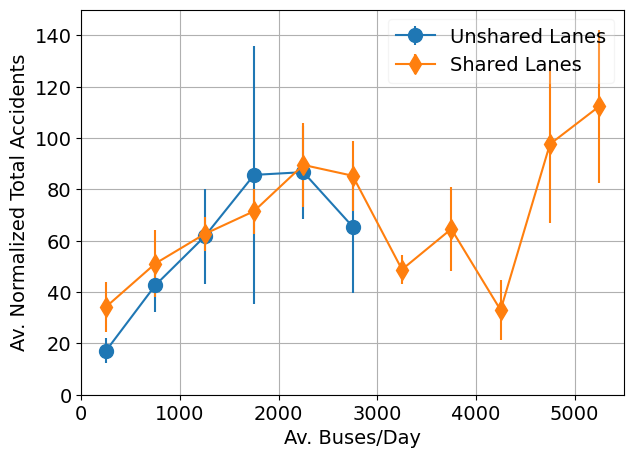

In [27]:
#just plot normalized total vs. av. buses/day

fig,ax = plt.subplots(figsize=(7,5))
labsize=14
ticksize=14
legsize=14
msize = 10

mtype = ['o','d']
    
nn = 0
for ii in range(2):
    if BoolVal[ii]:
        lab_str = 'Shared Lanes'
    else:
        lab_str = 'Unshared Lanes'
    ax.errorbar(b_bus,H_tot_bus[ii],H_err[ii],marker=mtype[ii],
              label='%s'%(lab_str),markersize=msize)
    
ax.set_xlabel('Av. Buses/Day',fontsize=labsize)
ax.set_ylabel('Av. Normalized Total Accidents',fontsize=labsize)
ax.tick_params(labelsize=ticksize)
ax.legend(fontsize=legsize,fancybox=True,framealpha=0.2)
ax.set_ylim(0,150)
ax.grid('on')

path = os.getcwd()
fname = os.path.join(path,'SharedLaneResults_1plot.png')
plt.savefig(fname,dpi=500, format=None, metadata=None,
        bbox_inches='tight',
        facecolor='white', edgecolor=None)
plt.show()

In [23]:
#look at unshared road that seemingly has no accidents
I = Igroup[gk] & (df_cluster[f_class] == False) & (df_cluster[f_class_2] == True)
Ibin = logic_win(df_cluster[f_bin].values,(3000,3500))
I &= Ibin
print(df_cluster.loc[I,'aadf_Pedal_cycles'])
df_cluster.loc[I]

2003    58.357143
Name: aadf_Pedal_cycles, dtype: float64


,ID,total,slight,serious,bikelane,aadf_Road_name,aadf_Road_category,aadf_Road_type,aadf_CLT_CARR,aadf_CLT_SEGREG,...,total_dnorm,total_dnorm_bvnorm,serious_ratio,distance_to_cp,total_dnorm_LL,aadf_Pedal_cycles_s,aadf_All_motor_vehicles_s,aadf_All_HGVs_s,aadf_LGVs_s,aadf_Buses_and_coaches_s
2003,38647,0,0,0,True,A1251,PA,Major,True,False,...,0.0,0.0,-9.0,-9.0,0.0,-0.712069,-0.036431,-0.367679,-0.414062,2.767782
